In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [30]:
data_root = '/home/therock/data2/my_code/udacity/deep_learning/udacity_git/data'
train_data = os.path.join(data_root, 'train')
valid_data = os.path.join(data_root, 'valid')
test_data = os.path.join(data_root, 'test')

im_dim = 299  # for inception v3
batch_size = 256
num_workers = 16
train_transform = transforms.Compose([
    transforms.Resize((im_dim,im_dim)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((im_dim,im_dim)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_data, transform=train_transform)
valid_dataset = datasets.ImageFolder(valid_data, transform=test_transform)
test_dataset = datasets.ImageFolder(test_data, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=num_workers)

### CNN model

In [31]:
class CancerDetect(nn.Module):
    def __init__(self, out_dim=3):
        super(CancerDetect, self).__init__()
        self.model = models.inception_v3(pretrained=True, progress=True, aux_logits=False)

        for p in self.model.parameters():
            p.requires_grad = False

        self.param_to_train = []

        for p in self.model.Mixed_7c.parameters():
            p.requires_grad = True
            self.param_to_train.append(p)

        self.model.fc = nn.Sequential(nn.Linear(2048, 1000), nn.ReLU(),
                                      nn.Linear(1000, 512), nn.ReLU(),
                                      nn.Linear(512, 256), nn.ReLU(),
                                      nn.Linear(256, 3))

        for p in self.model.fc.parameters():
            self.param_to_train.append(p)

    def parameters():
        return self.param_to_train

    def forward(self, x):
        return self.model(x)

In [32]:
model = CancerDetect()
model = model.to(device)
model.model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.model.parameters(), lr=0.001)

### Test the pre-trained Inception only ( without training using cancer data image)

In [34]:
test_loss = 0
test_correct = 0
test_total = 0
model.eval()
with torch.no_grad():

    for data, target in tqdm(test_loader):
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        tloss = criterion(output, target)
        test_loss += tloss.item()

        pred = output.data.max(1, keepdim=True)[1]
        test_correct += np.sum(
                np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        test_total += data.size(0)

test_loss /= len(test_loader)
test_accuracy = test_correct / test_total
print(f'test_loss = {test_loss} test_acc = {test_accuracy*100}%')


test_loss = 1.0948213338851929 test_acc = 64.0%


In [39]:
epochs = 20
best_valid_accuracy = 0
model_save_name = 'inception_cancer_model.pt'
train_accuracy_list = []
valid_accuracy_list = []

for i in range(epochs + 1):
    i += 1
    train_epoch_loss = 0
    model.train()
    train_correct = 0
    train_total = 0
    desc = 'Training epoch {}'.format(i)
    for data, target in tqdm(train_loader, desc=desc):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)

        output = model(data)
        loss = criterion(output, target)

        train_epoch_loss += loss.item()
        pred = output.data.max(1, keepdim=True)[1]

        train_correct += np.sum(
            np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        train_total += data.size(0)
        loss.backward()
        optimizer.step()

    train_epoch_loss /= len(train_loader)
    train_accuracy = train_correct / train_total
    train_accuracy_list.append(train_accuracy)

    valid_loss = 0
    valid_correct = 0
    valid_total = 0
    desc = 'Validation epoch {}'.format(i)
    with torch.no_grad():
        model.eval()
        for data, target in tqdm(valid_loader, desc=desc):
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            vloss = criterion(output, target)
            valid_loss += vloss.item()

            pred = output.data.max(1, keepdim=True)[1]
            valid_correct += np.sum(
                np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            valid_total += data.size(0)

    valid_loss /= len(valid_loader)
    valid_accuracy = valid_correct / valid_total
    
    if valid_accuracy > best_valid_accuracy:
        print(f'saving model...')
        torch.save(model.state_dict(), model_save_name)
        best_valid_accuracy = valid_accuracy

    valid_accuracy_list.append(valid_accuracy)
    print(
        f'epoch {i}/{epochs} train_loss = {train_epoch_loss} train_acc = {train_accuracy*100}% valid_loss = {valid_loss} valid_acc = {valid_accuracy*100}%'
    )


saving model...
epoch 1/20 train_loss = 0.478066623210907 train_acc = 68.8% valid_loss = 0.8993910551071167 valid_acc = 57.99999999999999%



saving model...
epoch 2/20 train_loss = 0.4153604991734028 train_acc = 83.6% valid_loss = 0.8756371140480042 valid_acc = 66.66666666666666%



saving model...
epoch 3/20 train_loss = 0.3234243802726269 train_acc = 88.94999999999999% valid_loss = 0.8790901899337769 valid_acc = 73.33333333333333%



epoch 4/20 train_loss = 0.2176661528646946 train_acc = 92.4% valid_loss = 1.6963152885437012 valid_acc = 68.0%



epoch 5/20 train_loss = 0.15408681519329548 train_acc = 94.75% valid_loss = 1.2166364192962646 valid_acc = 67.33333333333333%



epoch 6/20 train_loss = 0.19802080281078815 train_acc = 93.35% valid_loss = 0.943220853805542 valid_acc = 72.0%



saving model...
epoch 7/20 train_loss = 0.1481625558808446 train_acc = 94.95% valid_loss = 1.1664481163024902 valid_acc = 74.66666666666667%



epoch 8/20 train_loss = 0.11037820391356945 train_acc = 96.5% valid_loss = 1.2162575721740723 valid_acc = 74.66666666666667%



epoch 9/20 train_loss = 0.07389914430677891 train_acc = 97.75% valid_loss = 1.1530758142471313 valid_acc = 71.33333333333334%



epoch 10/20 train_loss = 0.05675735557451844 train_acc = 98.05% valid_loss = 1.2325806617736816 valid_acc = 72.0%



epoch 11/20 train_loss = 0.05513429851271212 train_acc = 98.0% valid_loss = 1.203064203262329 valid_acc = 72.0%



epoch 12/20 train_loss = 0.0376780079677701 train_acc = 98.35000000000001% valid_loss = 1.282670021057129 valid_acc = 72.66666666666667%



epoch 13/20 train_loss = 0.022517238627187908 train_acc = 99.25% valid_loss = 1.8616011142730713 valid_acc = 72.0%



epoch 14/20 train_loss = 0.03196676052175462 train_acc = 99.2% valid_loss = 1.5374877452850342 valid_acc = 74.66666666666667%



epoch 15/20 train_loss = 0.03580532397609204 train_acc = 98.6% valid_loss = 1.5071755647659302 valid_acc = 72.66666666666667%



epoch 16/20 train_loss = 0.021110133384354413 train_acc = 99.35000000000001% valid_loss = 1.6080323457717896 valid_acc = 72.0%



epoch 17/20 train_loss = 0.022329125204123557 train_acc = 99.25% valid_loss = 2.0603511333465576 valid_acc = 68.0%



epoch 18/20 train_loss = 0.024592883826699108 train_acc = 98.9% valid_loss = 1.499170184135437 valid_acc = 65.33333333333333%



epoch 19/20 train_loss = 0.028886953310575336 train_acc = 99.05000000000001% valid_loss = 1.4385910034179688 valid_acc = 71.33333333333334%



epoch 20/20 train_loss = 0.0314391435822472 train_acc = 99.15% valid_loss = 1.504175066947937 valid_acc = 74.0%



epoch 21/20 train_loss = 0.03813128377078101 train_acc = 99.25% valid_loss = 1.7022079229354858 valid_acc = 70.66666666666667%


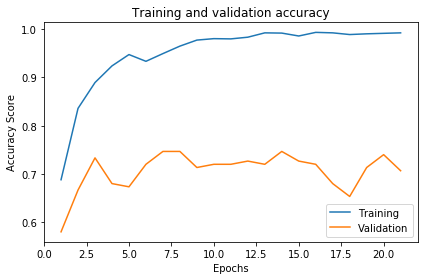

In [40]:
plt.plot(np.arange(1, 22, 1),train_accuracy_list, label="Training")
plt.plot(np.arange(1, 22, 1),valid_accuracy_list, label="Validation")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

### Test the re-trained Inception Net

In [41]:
test_loss = 0
test_correct = 0
test_total = 0
model.load_state_dict(torch.load(model_save_name))
model.eval()
with torch.no_grad():

    for data, target in tqdm(test_loader):
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        tloss = criterion(output, target)
        test_loss += tloss.item()

        pred = output.data.max(1, keepdim=True)[1]
        test_correct += np.sum(
                np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        test_total += data.size(0)

test_loss /= len(test_loader)
test_accuracy = test_correct / test_total
print(f'test_loss = {test_loss} test_acc = {test_accuracy*100}%')


test_loss = 1.7281470894813538 test_acc = 71.83333333333334%
